# 02 – Data Preprocessing and Exploratory Analysis

This notebook transforms raw daily price data into **monthly returns** and performs an initial exploratory analysis of the investment universe.  
The goal is to understand the statistical properties, correlations, and dynamics of the dataset before constructing the momentum signal.

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import os

In [4]:
data = pd.read_csv("data/raw/sp500_20.csv", index_col=0, parse_dates=True)

## 1. Convert Daily Prices to Monthly Frequency
We aggregate daily adjusted close prices to end-of-month values using `resample('ME').last()`.  
This reduces noise and aligns all assets on a common monthly timeline for backtesting.

In [5]:
monthly_prices = data.resample("ME").last()

## 2. Compute Monthly Returns
Monthly returns are calculated as the percentage change of end-of-month prices. This time series will be used in the momentum ranking and portfolio construction stages.

In [6]:
monthly_returns = monthly_prices.pct_change().dropna()
os.makedirs("data/processed", exist_ok=True)
monthly_returns.to_csv("data/processed/sp500_20_returns.csv")

In [7]:
cumulative_returns = (1 + monthly_returns).cumprod()

## 3. Visualize Price Evolution
The plot below shows the normalized price evolution of all stocks in the universe from 2000 to 2025.  
This helps visualize long-term trends and identify potential outliers (e.g., exceptionally strong performers like Apple or Amazon).

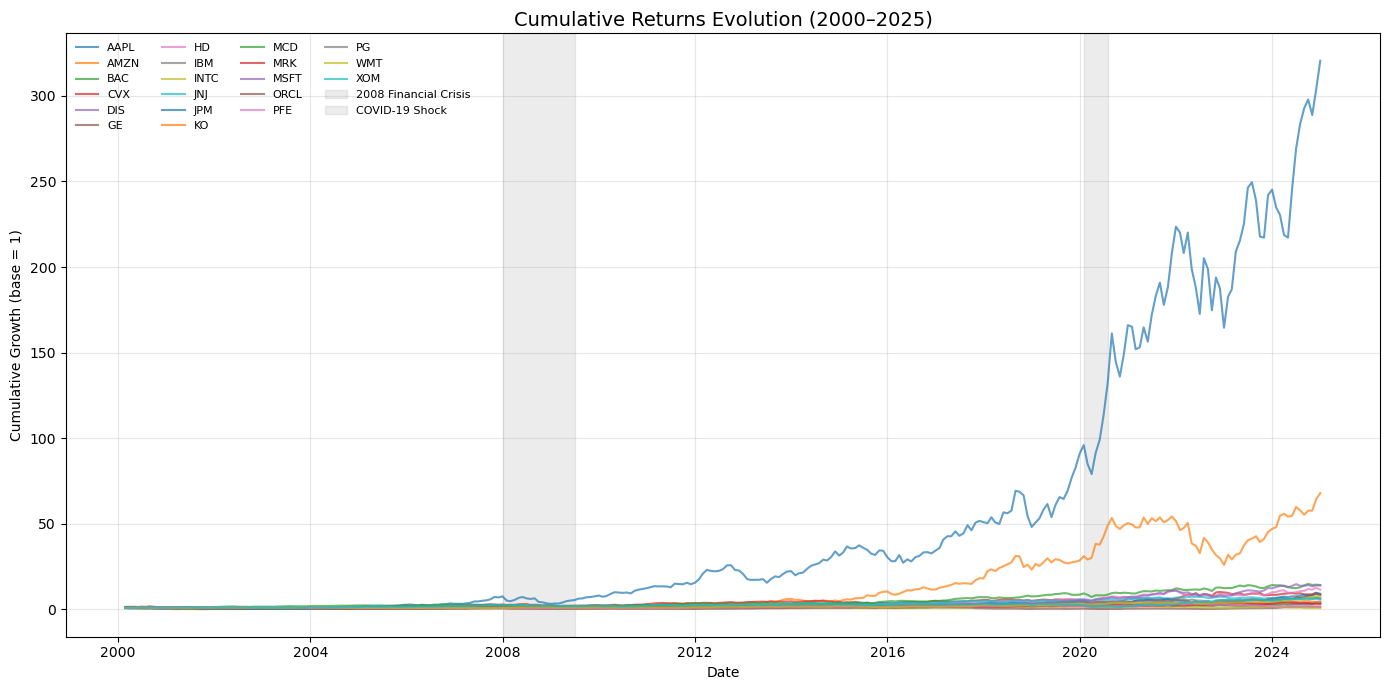

In [18]:
plt.figure(figsize=(14, 7))
for ticker in cumulative_returns.columns:
    plt.plot(cumulative_returns.index, cumulative_returns[ticker], label=ticker, alpha=0.7)

plt.title("Cumulative Returns Evolution (2000–2025)", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Cumulative Growth (base = 1)")

plt.axvspan(pd.Timestamp("2008-01-01"), pd.Timestamp("2009-06-30"),
            color="gray", alpha=0.15, label="2008 Financial Crisis")
plt.axvspan(pd.Timestamp("2020-02-01"), pd.Timestamp("2020-07-31"),
            color="gray", alpha=0.15, label="COVID-19 Shock")

plt.legend(ncol=4, fontsize=8, frameon=False)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [9]:
tickers_no_outliers = [t for t in monthly_returns.columns if t not in ["AAPL", "AMZN"]]
monthly_returns_no_outliers = monthly_returns[tickers_no_outliers]
cumulative_returns_no_outliers = (1 + monthly_returns_no_outliers).cumprod()

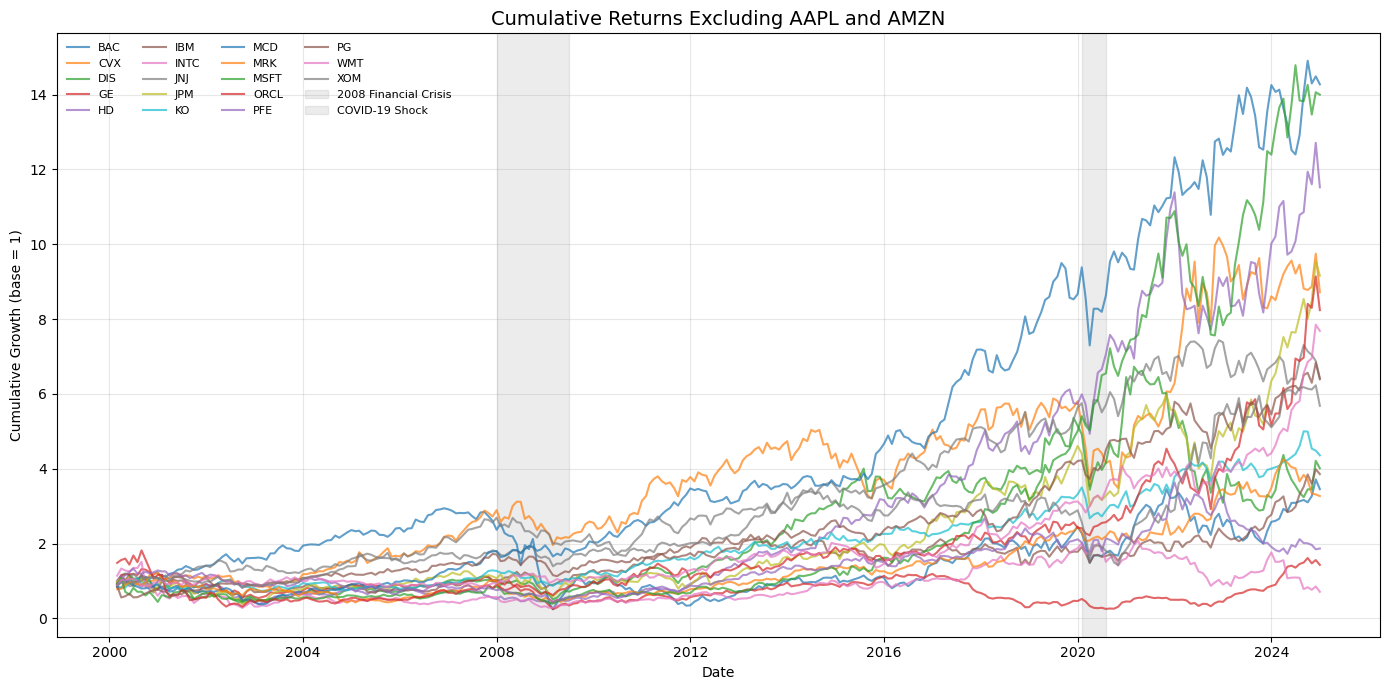

In [10]:
plt.figure(figsize=(14, 7))
for ticker in cumulative_returns_no_outliers.columns:
    plt.plot(cumulative_returns_no_outliers.index, 
             cumulative_returns_no_outliers[ticker], 
             label=ticker, alpha=0.7)

plt.title("Cumulative Returns Excluding AAPL and AMZN", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Cumulative Growth (base = 1)")

plt.axvspan(pd.Timestamp("2008-01-01"), pd.Timestamp("2009-06-30"),
            color="gray", alpha=0.15, label="2008 Financial Crisis")
plt.axvspan(pd.Timestamp("2020-02-01"), pd.Timestamp("2020-07-31"),
            color="gray", alpha=0.15, label="COVID-19 Shock")

plt.legend(ncol=4, fontsize=8, frameon=False)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 4. Correlation Analysis
The heatmap below displays pairwise correlations between monthly returns.  
High correlations indicate similar sector or market exposure, while low correlations suggest diversification benefits.  
Two versions are produced:
- Including all tickers.  
- Excluding extreme performers (e.g., Apple, Amazon) to examine robustness.

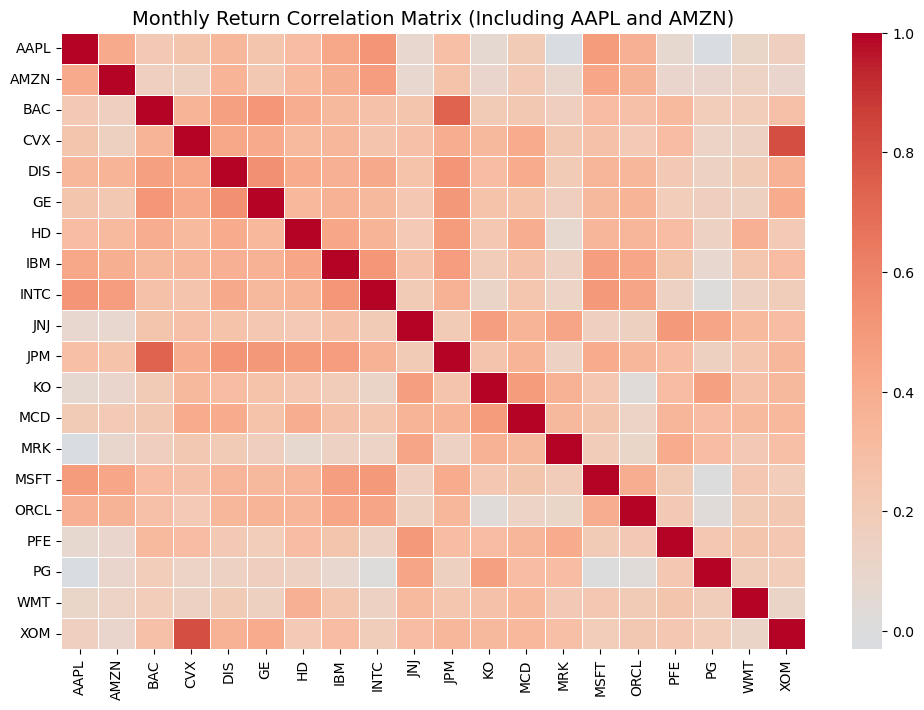

In [19]:
corr_all = monthly_returns.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_all, annot=False, cmap="coolwarm", center=0, linewidths=0.5)
plt.title("Monthly Return Correlation Matrix (Including AAPL and AMZN)", fontsize=14)
plt.show()

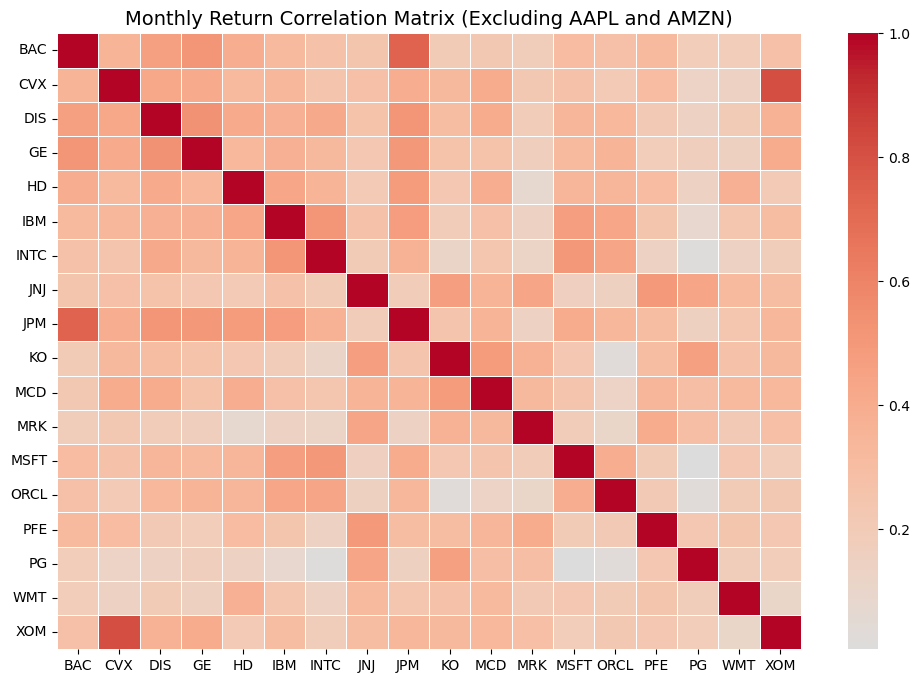

In [20]:
corr_no_outliers = monthly_returns_no_outliers.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_no_outliers, annot=False, cmap="coolwarm", center=0, linewidths=0.5)
plt.title("Monthly Return Correlation Matrix (Excluding AAPL and AMZN)", fontsize=14)
plt.show()

## 5. Descriptive Statistics
We summarize the main characteristics of the monthly returns for each asset:
- **Mean:** average monthly return  
- **Volatility:** standard deviation of monthly returns  
- **Skewness:** symmetry of the distribution (positive = right tail)  
- **Kurtosis:** tail heaviness relative to the normal distribution

These indicators help assess whether returns are approximately normal or exhibit heavy tails.

In [13]:
desc_stats = monthly_returns.describe().T
desc_stats["mean"] = monthly_returns.mean()
desc_stats["volatility"] = monthly_returns.std()
desc_stats["skewness"] = monthly_returns.skew()
desc_stats["kurtosis"] = monthly_returns.kurt()

desc_stats[["mean", "volatility", "skewness", "kurtosis"]].round(3)

,mean,volatility,skewness,kurtosis
AAPL,0.026,0.111,-0.588,3.581
AMZN,0.022,0.128,0.441,3.559
BAC,0.010,0.110,0.362,8.656
CVX,0.010,0.068,0.407,2.107
DIS,0.008,0.077,0.049,1.137
GE,0.005,0.088,0.217,2.255
HD,0.011,0.072,-0.161,0.267
IBM,0.007,0.072,0.365,3.208
INTC,0.004,0.099,-0.484,2.251
JNJ,0.007,0.047,-0.153,1.141


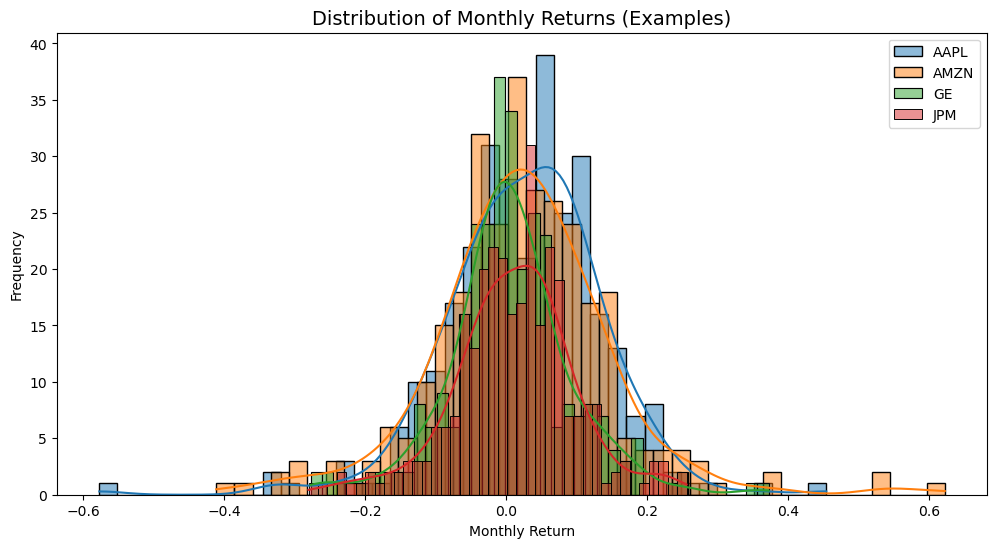

In [22]:
plt.figure(figsize=(12,6))
for ticker in ["AAPL", "AMZN", "GE", "JPM"]:  # 4 different examples
    sns.histplot(monthly_returns[ticker], kde=True, bins=40, label=ticker, alpha=0.5)

plt.title("Distribution of Monthly Returns (Examples)", fontsize=14)
plt.xlabel("Monthly Return")
plt.ylabel("Frequency")
plt.legend()
plt.show()

## 6. Comparison with Market Benchmark (SPY)
To contextualize our universe, we compute the average return and volatility of the portfolio and compare them with the SPY benchmark.  
This provides a quick view of how representative and diversified the dataset is relative to the broader market.

In [23]:
spy = yf.download("SPY", start="2000-01-01", end="2025-01-01", auto_adjust=True)["Close"]
spy_monthly = spy.resample("ME").last().pct_change().dropna()

universe_mean_returns = monthly_returns.mean(axis=1)

spy_mean = spy_monthly.mean().item()
spy_vol = spy_monthly.std().item()

universe_mean = universe_mean_returns.mean()
universe_vol = universe_mean_returns.std()

# --- Tabla comparativa ---
comparison = pd.DataFrame({
    "Monthly mean": [spy_mean, universe_mean],
    "Monthly volatility": [spy_vol, universe_vol]
}, index=["SPY", "Universe (20 tickers)"])

print(comparison.round(4))

[*********************100%***********************]  1 of 1 completed

                       Monthly mean  Monthly volatility
SPY                          0.0073              0.0441
Universe (20 tickers)        0.0098              0.0438


### Summary
- Converted daily prices to monthly returns for all tickers (2000–2025).  
- Explored distributional properties and cross-correlations.  
- Compared universe statistics against SPY benchmark.  
- Dataset is now clean, validated, and ready for **momentum signal construction** in the next notebook.